# Description

This notebook demonstrates making a simulation of particles moving around using numpy functionality.

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pdb

from matplotlib import animation
from itertools import combinations 

# Parameters

Physical parameters

In [2]:
NR_PARTICLES = 200
INIT_SPEED = 500
MAX_SPEED = 3e8
COLLISION_RADIUS = 0.06
SEED = 42
DELTA_T = 8e-6
EPS = 1e-6
BOUNDARY_COLLISION_SPEED_LOSS = 1.0

Visualization

In [3]:
plt.style.use(['dark_background'])

In [4]:
HIST_BINS = np.linspace(0, 1500, 50)
SIMULATION_TIMESTEPS = 1000

Derived parameters

In [5]:
COLLISION_RADIUS_SQ = COLLISION_RADIUS ** 2
ALL_PAIR_IDX = np.array(list(combinations(range(NR_PARTICLES), 2)), dtype=np.int64)
ALL_PAIR_IDX_T = np.ascontiguousarray(np.transpose(ALL_PAIR_IDX))

# Initialization

In [6]:
def reset_x():
    np.random.seed(SEED)
    return np.random.random((NR_PARTICLES, 2))

In [7]:
x = reset_x()

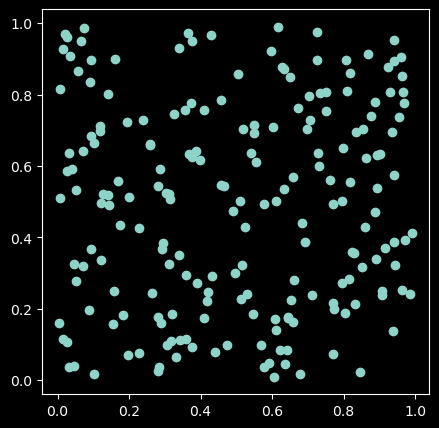

In [8]:
plt.figure(figsize=(5, 5))
plt.scatter(x[:, 0], x[:, 1]);

In [9]:
init_right_x = x[:, 0] > 0.5
init_left_x = x[:, 0] <= 0.5

In [10]:
def plot_from_init_positions(x, init_right_x, init_left_x):
    plt.scatter(*np.transpose(x[init_right_x]), c='r', s=50);
    plt.scatter(*np.transpose(x[init_left_x]), c='b', s=50);

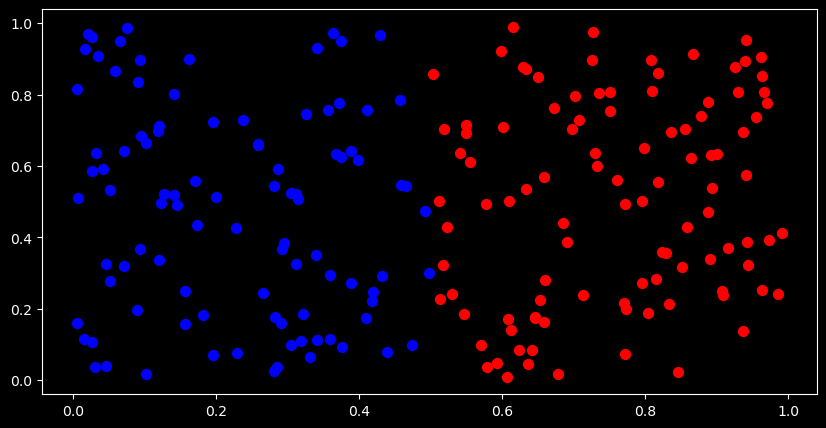

In [11]:
plt.figure(figsize=(10, 5))
plot_from_init_positions(x, init_right_x, init_left_x)

Initialize all the velocities at running towards the opposite end of the box. About 500 m/s is the actual speed of particles on eath at room temperature.

In [12]:
def reset_velocities(nr_particles):
    v = np.zeros((nr_particles, 2), dtype=np.float64)
    v[init_right_x, 0] = -INIT_SPEED
    v[init_left_x, 0] = INIT_SPEED
    return v

In [13]:
v = reset_velocities(NR_PARTICLES)

# Looking at every pair of particles

We have to look at all pairs of particles, which is a candidate for something that can be done in paralell.

In [14]:
%timeit np.square(x[ALL_PAIR_IDX_T[0]] - x[ALL_PAIR_IDX_T[1]]).sum(axis=0)

724 µs ± 7.33 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [15]:
def get_collision_mask(x, pair_idx):
    differences = x[pair_idx[1]] - x[pair_idx[0]]
    distances = np.square(differences).sum(axis=1)
    distances = np.clip(distances, EPS, 2)
    collision_mask = distances < COLLISION_RADIUS_SQ
    return differences, distances, collision_mask

In [16]:
differences, distances, collision_mask = get_collision_mask(x, ALL_PAIR_IDX_T)

# Elastic Collision Model

## Get all inverse distances squared, x differences and v differences

There are this many collisions to update.

In [17]:
collision_mask.sum()

229

Make a function that calculates differences for x, v and inverse difference squared.

In [18]:
def get_collision_vx_differences(v, pair_idx, mask, diffs, dists):
    update_v_diffs = v[pair_idx[1, mask]] - v[pair_idx[0, mask]]
    update_x_diffs = diffs[mask]
    update_x_dists_inv_sq = 1 / dists[mask]
    return update_v_diffs, update_x_diffs, update_x_dists_inv_sq

In [19]:
update_v_diffs, update_x_diffs, update_x_dists_inv_sq = get_collision_vx_differences(
    v, ALL_PAIR_IDX_T, collision_mask, differences, distances
)

Assert that first instance of a collision has the expected difference. This assumes that there is a first collision.

In [20]:
first_ind = collision_mask.argmax()

In [21]:
expected_inv_distance_squared = 1 / np.square(x[ALL_PAIR_IDX_T[1, first_ind]] - x[ALL_PAIR_IDX_T[0, first_ind]]).sum()

In [22]:
np.testing.assert_allclose(update_x_diffs[0], x[ALL_PAIR_IDX_T[1, first_ind]] - x[ALL_PAIR_IDX_T[0, first_ind]])

In [23]:
np.testing.assert_allclose(update_x_dists_inv_sq[0], expected_inv_distance_squared)

## Update the velocities from a collision

Define a helper function to make a scalar vector compaitible with multipying a 2d vector (element-wise).

In [24]:
def expand_to_2d_vector(scalar):
    expanded_vector = np.repeat(np.expand_dims(scalar, axis=0), 2, axis=0)
    return np.transpose(expanded_vector)

We assume the conservation of energy, momentum and angular momentum.

We see that the collision does nothing if the velocities are the same or the positions are exactly the same (which should never happen).

In [25]:
def change_velocity_of_colliding_particles(v1_v2_diff, r1_r2_diff, r1_r2_diff_inv_sq):
    magnitude = (v1_v2_diff * r1_r2_diff).sum(axis=1)
    magnitude *= r1_r2_diff_inv_sq
    magnitude = expand_to_2d_vector(magnitude)
    return r1_r2_diff * magnitude

In [26]:
%timeit change_velocity_of_colliding_particles(update_v_diffs, update_x_diffs, update_x_dists_inv_sq)

17.5 µs ± 190 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [27]:
delta_velocity = change_velocity_of_colliding_particles(update_v_diffs, update_x_diffs, update_x_dists_inv_sq)

## Check the update velocity calculation is correct

In [28]:
max_vec_id = delta_velocity.argmax() // 2

In [29]:
max_v_update = delta_velocity[max_vec_id]; max_v_update

array([331.00158052, 470.57362252])

In [30]:
max_v_diff = update_v_diffs[max_vec_id]; max_v_diff

array([1000.,    0.])

In [31]:
max_x_diff = update_x_diffs[max_vec_id]; max_x_diff

array([-0.01972652, -0.02804452])

In [32]:
max_inv_r_sq = update_x_dists_inv_sq[max_vec_id]; max_inv_r_sq

850.6069921713816

Now assert the formula is correct. This assumes there was a collision.

In [33]:
np.testing.assert_allclose(max_v_update, np.dot(max_v_diff, max_x_diff) * max_inv_r_sq * max_x_diff)

## Update all the velocities

There is a min and max velocity. Initially, only two particles near the boundary will collide. 

In [34]:
v.min(), v.max()

(-500.0, 500.0)

In [35]:
collision_i, collision_j = ALL_PAIR_IDX[collision_mask][max_vec_id]; collision_i, collision_j

(137, 170)

Since multiple indices have to be modified then we have to some over each unique index.

In [36]:
def sum_over_unique_ids(idx, arr):
    idx_unique = np.unique(idx)
    arr_sum_changes = np.array([arr[idx == i].sum(axis=0) for i in idx_unique], dtype=np.float64)
    return idx_unique, arr_sum_changes

There is an energy preserving scalar term which is usually one but with multiple collisions, we do the adjustment. In real life, multiple collisions cannot occur simultaenously.

In [37]:
def update_velocities(v, pair_idx, mask, delta_v):
    first_idx, second_idx = np.transpose(pair_idx[mask])
    if len(first_idx) == 0:
        return v

    first_idx_unique, first_particle_sum_changes = sum_over_unique_ids(first_idx, delta_v)
    second_idx_unique, second_particle_sum_changes = sum_over_unique_ids(second_idx, delta_v)
    all_idx_unique = np.unique(np.concatenate([first_idx_unique, second_idx_unique]))

    original_energy = np.square(v[all_idx_unique]).sum(axis=1)
    v[first_idx_unique] += first_particle_sum_changes
    v[second_idx_unique] -= second_particle_sum_changes

    new_energy = np.square(v[all_idx_unique]).sum(axis=1)
    scalar = np.sqrt(original_energy / new_energy)
    v[all_idx_unique] *= expand_to_2d_vector(scalar)

    return v

In [38]:
v_i_old = v[collision_i].copy()
v_j_old = v[collision_j].copy()
v_i_old, v_j_old

(array([-500.,    0.]), array([500.,   0.]))

In [39]:
first_idx, second_idx = np.transpose(ALL_PAIR_IDX[collision_mask])

In [40]:
v_copy = v.copy()

This operation takes a bit longer than ideal because of summing for each unique index on an array that we know is sorted by index.

In [41]:
%timeit update_velocities(v_copy, ALL_PAIR_IDX, collision_mask, delta_velocity)

1.58 ms ± 10.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [42]:
v = update_velocities(v, ALL_PAIR_IDX, collision_mask, delta_velocity)

## Check that change is as expected

Note that each collision can have multiple collisions with other particles simultaneously.

In [43]:
delta_velocity[collision_i == first_idx]

array([[331.00158052, 470.57362252]])

In [44]:
delta_velocity[collision_i == second_idx]

array([], shape=(0, 2), dtype=float64)

Each collision has an effect from the positive end and the negative receiving end of the collision.

In [45]:
expected_change_i = delta_velocity[collision_i == first_idx].sum(axis=0)
expected_change_i -= delta_velocity[collision_i == second_idx].sum(axis=0)
expected_change_i

array([331.00158052, 470.57362252])

In [46]:
expected_change_j = delta_velocity[collision_j == first_idx].sum(axis=0)
expected_change_j -= delta_velocity[collision_j == second_idx].sum(axis=0)
expected_change_j

array([-645.58788973,   -6.22271721])

In [47]:
old_energy = np.dot(v_i_old, v_i_old) + np.dot(v_j_old, v_j_old)

In [48]:
v_i_new = v_i_old + expected_change_i
v_j_new = v_j_old + expected_change_j

In [51]:
v[collision_i], v[collision_j]

(array([-168.99841948,  470.57362252]), array([-499.54390524,  -21.3515043 ]))

In [52]:
np.testing.assert_allclose(v[collision_i], v_i_new)

# Run the Entire Simulation

## Make sure that positions are clipped in a box

If a particle reaches the boundary one of the components of the velocity must point in the other direction.

In [56]:
def clip_on_axis(x, v, axis):
    x_too_big = x[:, axis] > 1
    v[x_too_big, axis] = -np.abs(v[x_too_big, axis]) * BOUNDARY_COLLISION_SPEED_LOSS

    x_too_small = x[:, axis] < 0
    v[x_too_small, axis] = np.abs(v[x_too_small, axis]) * BOUNDARY_COLLISION_SPEED_LOSS

    return x, v

In [57]:
clip_on_axis(np.array([[0, 1.1]]), np.array([[0, 500]]), 1)

(array([[0. , 1.1]]), array([[   0, -500]]))

In [58]:
clip_on_axis(np.array([[-0.1, 1.0]]), np.array([[-500, 500]]), 0)

(array([[-0.1,  1. ]]), array([[500, 500]]))

In [59]:
def clip_particle_positions(x, v):
    x, v = clip_on_axis(x, v, 0)
    x, v = clip_on_axis(x, v, 1)
    return x, v

## Run the Simulation

In [60]:
def kinetic_energy(v):
    return 0.5 * np.square(v).sum()

In [61]:
def run_simulation_multiple_interactions(x, v, delta_t):
    x += delta_t * v
    x, v = clip_particle_positions(x, v)
    
    diffs, dists, mask = get_collision_mask(x, ALL_PAIR_IDX_T)
    update_v, update_x, update_dists_inv_sq = get_collision_vx_differences(v, ALL_PAIR_IDX_T, mask, diffs, dists)
    delta_velocity = change_velocity_of_colliding_particles(update_v, update_x, update_dists_inv_sq)
    v = update_velocities(v, ALL_PAIR_IDX, mask, delta_velocity)
    return x, v

The problem with the above approach is that multiple collisions can occur between multiple particles. This cannot happen in real life but as part of the model, we have to assume that one particle gets one impulse from another particle. The system can change kinetic energy over time.

In [62]:
def simulate_collisions(v, x, diffs, dists, mask):
    v1 = v[ALL_PAIR_IDX[mask, 0]]
    v2 = v[ALL_PAIR_IDX[mask, 1]]
    
    r_diff  = -diffs[mask]
    r_dists = dists[mask]
    magnitude = ((v1 - v2) * r_diff).sum(axis=1) / r_dists
    magnitude = np.repeat(np.expand_dims(magnitude, axis=0), 2, axis=0)
    delta_v = np.transpose(magnitude) * r_diff

    # Somehow, doing this preserves energy better than using += and -=
    v1new = v1 - delta_v
    v2new = v2 + delta_v

    v[ALL_PAIR_IDX[mask, 0]] = v1new
    v[ALL_PAIR_IDX[mask, 1]] = v2new

In [63]:
def run_simulation(x, v, delta_t):
    diffs, dists, mask = get_collision_mask(x, ALL_PAIR_IDX_T)

    simulate_collisions(v, x, diffs, dists, mask)

    x += delta_t * v
    x, v = clip_particle_positions(x, v)

    return x, v

Check the entire pipeline works.

In [64]:
v = reset_velocities(NR_PARTICLES)

In [65]:
print('Kinetic Energy', kinetic_energy(v))

Kinetic Energy 25000000.0


In [66]:
x, v = run_simulation_multiple_interactions(x, v, 0.)

In [67]:
print('Kinetic Energy', kinetic_energy(v))

Kinetic Energy 25000000.0


## Show multiple frames of the simulation

In [71]:
v = reset_velocities(NR_PARTICLES)
x = reset_x()

In [72]:
energies = []

for _ in range(SIMULATION_TIMESTEPS):
    run_simulation_multiple_interactions(x, v, DELTA_T)
    energies.append(kinetic_energy(v))

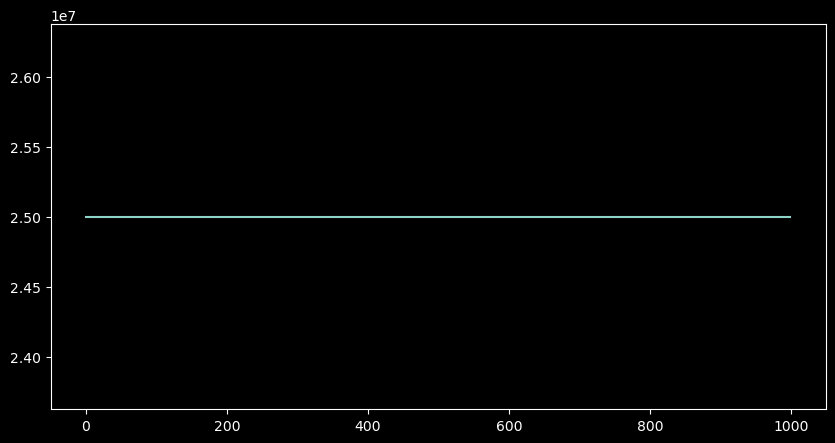

In [73]:
plt.figure(figsize=(10, 5))
plt.plot(energies);

# Create Animation

In [74]:
v = reset_velocities(NR_PARTICLES)
x = reset_x()

## Boltzmann Equation

In [75]:
input_velocity_v = np.linspace(0, 2000, 1000)
a_const = 2 / INIT_SPEED**2
boltzman_curve = a_const * input_velocity_v * np.exp(-a_const * input_velocity_v**2 / 2)

## Plot Histogram

In [76]:
def plot_velocity_histogram(v, boltzman_curve):
    plt.hist(np.sqrt(np.sum(v**2, axis=1)), bins=HIST_BINS, density=True)
    plt.plot(input_velocity_v, boltzman_curve)
    plt.xlabel('Velocity [m/s]')
    plt.ylabel('# Particles')

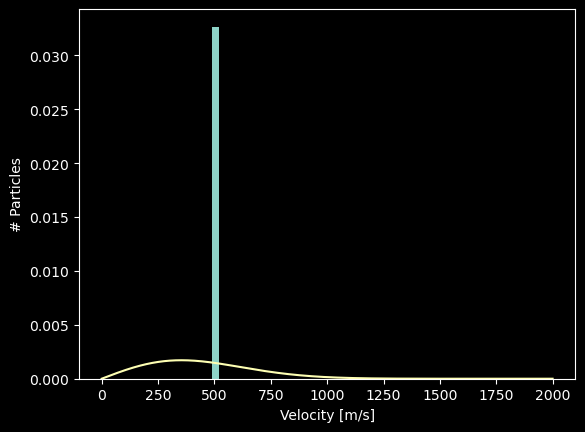

In [77]:
plot_velocity_histogram(v, boltzman_curve)

## Write animation

The initial distribution converges to Boltzmann but when the particles bouce off the walls of the box, more kinetic energy seems to be created. This can be dampened by having a coeficient of reduction in speed but this is just a guess to keep the energy under control.

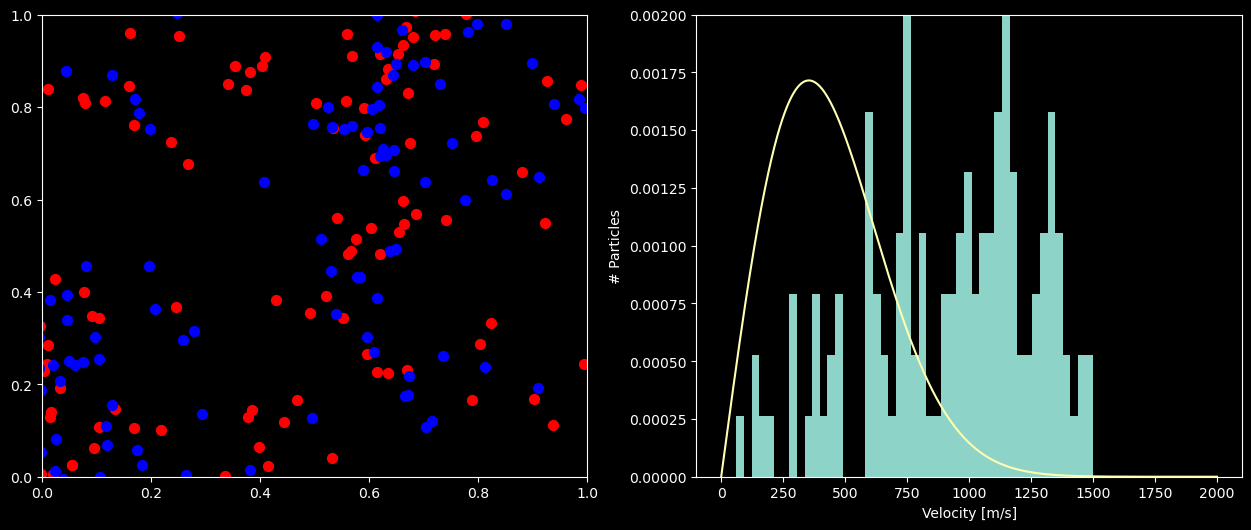

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

def animate(i):
    run_simulation(x, v, DELTA_T)

    ax[0].clear()
    ax[1].clear()

    plt.subplot(1, 2, 1)
    plt.subplots_adjust(left=0.1)
    plot_from_init_positions(x, init_right_x, init_left_x)

    ax[0].set_xlim(0, 1)
    ax[0].set_ylim(0, 1)

    plt.subplot(1, 2, 2)
    plt.subplots_adjust(right=0.9)
    plot_velocity_histogram(v, boltzman_curve)
    
    ax[1].set_ylim(0, 0.002)
    
ani = animation.FuncAnimation(fig, animate, frames=SIMULATION_TIMESTEPS, interval=50)
ani.save('particle_animation.gif', writer='pillow', fps=30, dpi=100)

# Conclusion

This simulation with multiple collisions creates realistic looking behaviour and ensures energy remains the same.

Both the original and the multiple particle simulation conerges to a Bolztmann dsitribution after a new iterations but then the energy diverges in the former case and the distribution changes in the latter case. The presence of elastic collisions with the boundary might be an issue.

The speed of the simulation without writing the images is a few ms but there is a good oppurunity for further speed improvements.